In [37]:
# Importing libraries
from random import sample
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
#from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [38]:
# Loading the dataset
#data = pd.read_csv('training_v2.csv')
data = pd.read_csv('C:/Users/kshah104/Documents/DSDJ/Kaggle WiDS Datathon/widsdatathon2020/training_v2.csv')
                   

## Data Preprocessing
### Class Imbalance
We find that this dataset is hugely imbalanced. There are very few observations of `hospital_death` = 1 as compared to `hospital_death` = 0. Once presented with previously unseen data, this can prove to be a problem since classification algorithms might classify all the entries as `hospital_death` = 0 in order to obtain a high accuracy. 

In [39]:
# Extracting the counts for each level of the target feature
data['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

### Resampling 

Resampling, as the name suggests, allows us to obtain a different sample of the data so as to ensure that both classes in our target variable are evenly distributed. Since we have almost 100,000 records in the dataset, we choose **downsampling technique** so that our dataset is reduced to something more manageable thereby also speeding up our first iteration of modeling. 

In [40]:
# Extracting the rows where hospital == 0
alive_data = data[data['hospital_death'] == 0].reset_index(drop=True)

# Generating indexes from 0 to 83798
idx = list(range(0,83798))

# Subset a sample without replacement from the indexes
random.seed(42)
subset = sample(idx, 7915)

# Subsetting the alive_data with the chosen indexes, reseting the index
alive_data = alive_data.loc[subset].reset_index(drop=True)

In [41]:
# Appending the alive_data with the observations where hospital_death == 1
new_data = alive_data.append(data[data['hospital_death'] == 1])

# Shuffling the dataset so the distribution of 0 and 1 is random throughout the dataset
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [42]:
new_data.shape

(15830, 186)

In [43]:
new_data.head(20)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,88430,2187,171,0,63.0,27.202216,1,Caucasian,M,190.0,PACU,Operating Room / Recovery,404,admit,CSICU,0.144444,0,98.2,NaN,202.0,1204.01,1,0.0,NaN,11.0,0.78,NaN,4.0,6.0,0.0,5.0,106.0,109.0,36.9,0.0,134.0,NaN,NaN,NaN,NaN,28.0,137.0,36.30,NaN,0.0,7.50,87.0,57.0,90.0,71.0,90.0,71.0,106.0,79.0,113.0,73.0,101.0,82.0,101.0,82.0,26.0,13.0,98.0,91.0,168.0,106.0,143.0,122.0,143.0,122.00,38.20,36.300,87.0,72.0,90.0,77.0,90.0,77.0,83.0,79.0,113.0,94.0,101.0,88.0,101.0,88.0,19.0,17.0,98.0,94.0,168.0,144.0,143.0,123.0,143.0,123.0,36.30,36.30,NaN,NaN,NaN,NaN,11.0,11.0,8.1,8.1,0.78,0.78,106.0,106.0,23.0,23.0,12.2,12.2,36.9,36.9,NaN,NaN,NaN,NaN,171.0,171.0,3.8,3.8,137.0,137.0,7.50,7.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
1,79169,67579,19,1,76.0,38.402118,0,Caucasian,M,177

### Split the feature variables and the target variable

In [44]:
X = new_data.drop('hospital_death', axis = 1)
y = new_data['hospital_death']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 22.3+ MB


### Missing values
This dataset contains a lot of missing values and we've employed various strategies throughout the notebook to deal with them. We first start with: 
1. **Drop rows that contain missing values greater than a 50% threshold.**
2. **Use the index of the rows in step 1 to drop the respective values from the target variable column.**

In [45]:
# Look at the row-wise percentage of missing values in X
X.isnull().mean(axis = 1)

0        0.335135
1        0.335135
2        0.394595
3        0.345946
4        0.486486
           ...   
15825    0.437838
15826    0.345946
15827    0.383784
15828    0.005405
15829    0.362162
Length: 15830, dtype: float64

In [46]:
# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X after dropping rows is (14636, 185)
The shape of y after dropping rows is (14636,)


### Feature Selection

We follow 2 strategies in order to reduce the number of dimensions in our dataset.
1. **Drop columns that contain missing values greater than a 75% threshold:**
> For example, the column `h1_pao2fio2ratio_min` is missing 83.5% of its data. 
2. **Drop coloumns based on manual evaluation of the data:**
> For example, drop the `id` columns since they don't provide any relevant information in predicting `hospital_death`.
> Drop the `height` and `weight` columns since they are collinear to the `bmi` column.
> Drop the `readmission_status` column since it contains all 0s. 

In [47]:
# Look at the column-wise percentage of missing values in X
row_majority_X.isnull().mean()

encounter_id                   0.000000
patient_id                     0.000000
hospital_id                    0.000000
age                            0.055411
bmi                            0.037442
                                 ...   
leukemia                       0.004031
lymphoma                       0.004031
solid_tumor_with_metastasis    0.004031
apache_3j_bodysystem           0.010180
apache_2_bodysystem            0.010180
Length: 185, dtype: float64

In [48]:
# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

(14636, 149)

In [49]:
# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight', 'readmission_status'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

The shape of X after dropping columns is (14636, 142)


### Feature Transformation
1. **Transforming `BMI` from a numerical to a categorical variable**

BMI Categories | BMI Values
--- | ---
Underweight | <18.5 =0
Normal weight | 18.5–24.9 =1
Overweight | 25–29.9 =2
Obesity | BMI of 30 or greater =3

2. **Transforming `pre_icu_los_days` from a numerical to a categorical variable**

pre_icu_los_days Categories | pre_icu_los_days Values
--- | ---
'0' | <= 0
'1' | > 0 and <= 5
'2' | > 5 and <= 10
'3' | > 10 and <= 15
'4' | > 15 and <= 20
'5' | > 20 and <= 25
'6' | > 25 and <= 30
'7' | => 30

In [50]:
# Transforming BMI to a categorical variable
def BMICat(x) :
    try :
        x = float(x)
        if (x >= 0) and (x < 18.5) : return 'Underweight'
        elif ((x >= 18.5 ) and (x <= 24.9)) : return 'Normal Weight'
        elif ((x >= 25 )   and (x <= 29.9)) : return 'Overweight'
        else : return 'Obese'
    except ValueError:
        return 'Other'

final_X['bmi'] = final_X['bmi'].apply(BMICat)

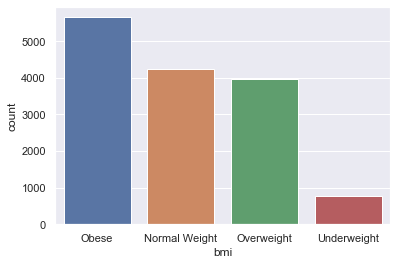

In [51]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['bmi'], order = final_X['bmi'].value_counts().index)
plt.show()

In [52]:
# Transforming pre_icu_los_days to a categorical variable
def PILDCat(x) :
    try :
        x = float(x)
        if (x <= 0)                : return 'Range[- to 0]'
        elif (x > 0) and (x <= 5) : return  'Range[1 to 5]'
        elif (x > 5) and (x <= 10) : return 'Range[5 to 10]'
        elif (x > 10) and (x <= 15) : return 'Range[11 to 15]'
        elif ((x > 15) and (x <= 20)) : return 'Range[16 to 20]'
        elif ((x > 20) and (x <= 25)) : return 'Range[21 to 25]'
        elif ((x > 25 ) and (x <= 30)) : return 'Range[25 to 30]'
               
        else : return 'Range[> 30]'
    except ValueError:
        return 'Other'

final_X['pre_icu_los_days']= final_X['pre_icu_los_days'].apply(PILDCat)

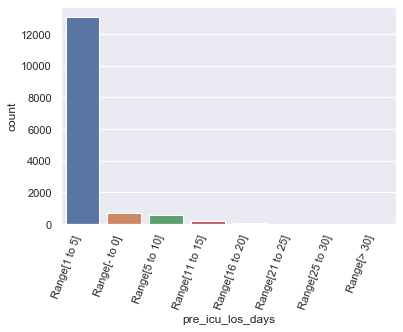

In [53]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['pre_icu_los_days'], order = final_X['pre_icu_los_days'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

### Split categorical and numerical variables

In [54]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('C:/Users/kshah104/Documents/DSDJ/Kaggle WiDS Datathon/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

### Dealing with categorical variables

There are still some missing values that need to be taken care of among our categorical variables so we evaluate them in order:
1. **ethnicity** 
> Impute the missing values with 'Other/Unknown' since the dataframe already has that value.
2. **gender** 
> We observe that there are only 6 missing values. Therefore, we decide to impute values as either 'M' or 'F' based on the percentage of these 2 classes in the column. Following that, we encode the values as follows:

Value | Encoding
--- | ---
'F' | 0
'M' | 1

3. **hospital_admit_source** and **icu_admit_source**
> On evaluating the 2 columns side by side, we find that `icu_admit_source` is conveying similar information as `hospital_admit_source` and also has fewer missing values than `hospital_admit_source`. Therefore we decide to drop `hospital_admit_source` and impute the missing values of `icu_admit_source` wuth 'Unknown'.
4. **apache_3j_bodysystem** and **apache_2_bodysystem** 
> On evaluating the 2 columns side by side, we find that `apache_3j_bodysystem` is conveying similar information as `apache_2_bodysystem`. Therefore we decide to drop `apache_2_bodysystem` and impute the missing values of `apache_3j_bodysystem` with 'Unknown'.
5. **arf_apache, intubated_apache, ventilated_apache, aids, cirrhosis, diabetes_mellitus, hepatic_failure         immunosuppression, leukemia, lymphoma, solid_tumor_with_metastasis**
> Upon observation, all these variables have missing values in the same records and hence we drop those records (using the index values) from X_cat, X_num and final_y. 
6. **gcs_unable_apache** 
> This variable tells us whether the Glasgow Coma Scale was unable to be assessed due to patient sedation and is dropped because this information has already been taken care of by 3 other columns - `gcs_eyes_apache`, `gcs_motor_apache` and `gcs_verbal_apache`. 

In [55]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

bmi                               0
elective_surgery                  0
ethnicity                       203
gender                            6
hospital_admit_source          3278
icu_admit_source                 16
icu_stay_type                     0
icu_type                          0
pre_icu_los_days                  0
apache_post_operative             0
arf_apache                       59
gcs_unable_apache                89
intubated_apache                 59
ventilated_apache                59
aids                             59
cirrhosis                        59
diabetes_mellitus                59
hepatic_failure                  59
immunosuppression                59
leukemia                         59
lymphoma                         59
solid_tumor_with_metastasis      59
apache_3j_bodysystem            149
apache_2_bodysystem             149
dtype: int64

In [56]:
# Value counts for ethnicity
print('The value counts for ethnicity are: \n{}'.format(X_cat['ethnicity'].value_counts()))

The value counts for ethnicity are: 
Caucasian           11324
African American     1490
Other/Unknown         667
Hispanic              624
Asian                 194
Native American       134
Name: ethnicity, dtype: int64


C:\Users\kshah104\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


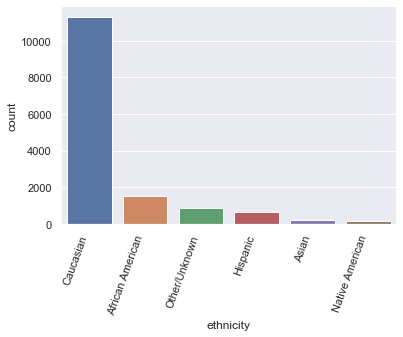

In [57]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Other/Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [58]:
# Percentage of gender classes
X_cat['gender'].value_counts(normalize=True)

M    0.540602
F    0.459398
Name: gender, dtype: float64

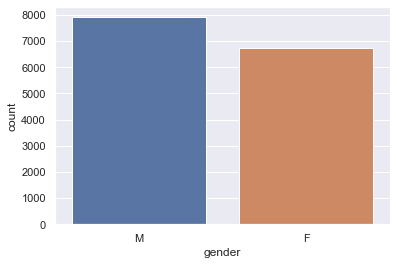

In [59]:
# Imputing values for gender
np.random.seed(0)
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna(pd.Series(np.random.choice(['M', 'F'], 
                                                      p=[0.54, 0.46], size=len(X_cat))))
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

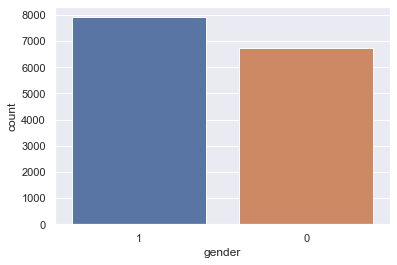

In [60]:
# Encoding gender as 1 and 0
X_cat.loc[:, 'gender'] = X_cat['gender'].replace({'F': 0, 'M': 1})
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [61]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Overweight,1,Caucasian,1,PACU,Operating Room / Recovery,admit,CSICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
1,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
2,Obese,0,Native American,0,NaN,Floor,admit,Med-Surg ICU,Range[1 to 5],0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
4,Underweight,0,African American,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,Obese,0,Native American,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14631,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Cardiac ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
14632,Underweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Respiratory,Respiratory
14633,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
14634,Obese,0,Caucasian,0,NaN,Floor,admit,Med-Surg ICU,Range[11 to 15],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


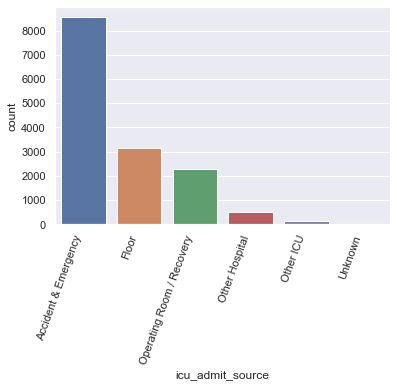

In [62]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [63]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
2,Obese,0,Native American,0,Floor,admit,Med-Surg ICU,Range[1 to 5],0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
4,Underweight,0,African American,0,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
6,Overweight,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
11,Obese,0,African American,0,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hematological,Haematologic
13,Obese,1,African American,0,Operating Room / Recovery,admit,Neuro ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,Neurological,Neurologic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14617,Normal Weight,0,Caucasian,0,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Sepsis,Cardiovascular
14620,Overweight,0,Caucasian,0,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
14621,Obese,0,Caucasian,0,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
14626,Normal Weight,0,African American,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


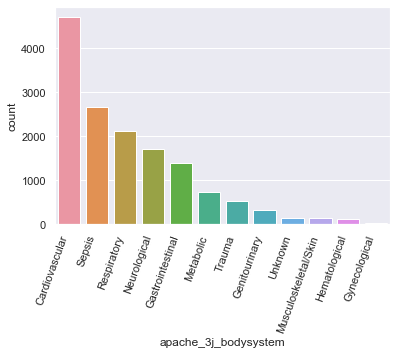

In [64]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [65]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                     59
gcs_unable_apache              89
intubated_apache               59
ventilated_apache              59
aids                           59
cirrhosis                      59
diabetes_mellitus              59
hepatic_failure                59
immunosuppression              59
leukemia                       59
lymphoma                       59
solid_tumor_with_metastasis    59
apache_3j_bodysystem            0
dtype: int64

In [66]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (14577, 22)
The shape of X_num after dropping rows is (14577, 118)
The shape of y after dropping rows is (14577,)


In [67]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                      0
gcs_unable_apache              30
intubated_apache                0
ventilated_apache               0
aids                            0
cirrhosis                       0
diabetes_mellitus               0
hepatic_failure                 0
immunosuppression               0
leukemia                        0
lymphoma                        0
solid_tumor_with_metastasis     0
apache_3j_bodysystem            0
dtype: int64

In [68]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

### Dealing with numerical variables

In [69]:
# Removing columns with more than len(X_num)-5000.
X_num_nonan = X_num.dropna(thresh=len(X_num) - 5000, axis=1)

# Concatenating the numerical and categorical features 
tmp = pd.concat([X_num_nonan, X_cat], axis=1)

# One-hot encoding the dataset
new_dataset = pd.get_dummies(tmp)
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown
0,63.0,202.0,1204.01,11.0,0.78,4.0,6.0,5.0,106.0,109.0,36.9,134.0,28.0,137.0,36.30,7.5,90.0,71.0,90.0,71.0,106.0,79.0,101.0,82.0,101.0,82.0,26.0,13.0,98.0,91.0,143.0,122.0,143.0,122.0,38.2,36.30,90.0,77.0,90.0,77.0,83.0,79.0,101.0,88.0,101.0,88.0,19.0,17.0,98.0,94.0,143.0,123.0,143.0,123.0,36.30,36.30,11.0,11.0,8.1,8.1,0.78,0.78,106.0,106.0,23.0,23.0,12.2,12.2,36.9,36.9,171.0,171.0,3.8,3.8,137.0,137.0,7.5,7.5,0.02,0.01,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,76.0,110.0,104.01,NaN,NaN,3.0,6.0,4.0,135.0,102.0,NaN,52.0,28.0,NaN,37.11,NaN,104.0,39.0,104.0,39.0,102.0,66.0,110.0,56.0,110.0,56.0,28.0,18.0,100.0,91.0,143.0,92.0,143.0,92.0,37.5,36.72,74.0,64.0,74.0,64.0,102.0,95.0,80.0,72.0,80.0,72.0,27.0,23.0,98.0,95.0,114.0,99.0,114.0,99.0,36.72,36.72,83.0,83.0,NaN,NaN,3.30,3.30,185.0,135.0,31.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,5.1,5.1,137.0,137.0,NaN,NaN,0.04,0.02,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,61.0,113.0,501.01,NaN,NaN,3.0,6.0,2.0,39.0,121.0,NaN,40.0,10.0,NaN,36.70,NaN,68.0,24.0,68.0,24.0,121.0,94.0,73.0,33.0,73.0,33.0,23.0

In [98]:
format(new_dataset.shape)

'(14577, 141)'

In [183]:
Col_Header = new_dataset.columns[1]
print(Col_Header)
print(type(Col_Header))

apache_2_diagnosis
<class 'str'>


In [184]:
print(Imp_features[1,])
print(type(Imp_features[1,]))

apache_4a_icu_death_prob
<class 'numpy.str_'>


In [202]:
print(len(Imp_features))

29


In [251]:
## Selecting the Important features based on the importance chart created in Random Forest


Imp_feature_list = ['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'gcs_verbal_apache',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'd1_creatinine_min',
 'd1_sysbp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_heartrate_max',
 'creatinine_apache',
 'd1_temp_min',
 'd1_bun_max',
 'd1_hco3_min',
 'd1_bun_min',
 'd1_sysbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'age',
 'apache_3j_diagnosis',
 'temp_apache',
 'd1_creatinine_max',
 'heart_rate_apache',
 'wbc_apache',
 'd1_platelets_min',
 'resprate_apache',
 'd1_platelets_max',
 'h1_resprate_max']

Imp_features = np.array(Imp_feature_list)

Imp_features.shape
## Code below is to drop the features that are not there in the above Imp_Features list.
#final_dataset = new_dataset
count = 0

for i in range (len(new_dataset.columns)):
    for j in range (len(Imp_features)):
          if ((new_dataset.columns[i]) == (Imp_features[j,])):
              count = count + 1
    if (count == 0):  
        column = new_dataset.columns[i]
        final_dataset = new_dataset.drop(column, axis =1)
        print(column)
        print(final_dataset.shape, "inside loop")
    count = 0        
    #print( "this is times", i) 
    
print(new_dataset.shape)
print(new_dataset.head)
print (count)                   
print(i)
print(j)
 
#if (new_dataset.columns[i]) != (Imp_features)):
 #   final_dataset = new_dataset.drop(column, axis =1)
    

bun_apache
(14577, 140) inside loop
gcs_eyes_apache
(14577, 140) inside loop
glucose_apache
(14577, 140) inside loop
hematocrit_apache
(14577, 140) inside loop
map_apache
(14577, 140) inside loop
sodium_apache
(14577, 140) inside loop
d1_diasbp_max
(14577, 140) inside loop
d1_diasbp_min
(14577, 140) inside loop
d1_diasbp_noninvasive_max
(14577, 140) inside loop
d1_diasbp_noninvasive_min
(14577, 140) inside loop
d1_heartrate_min
(14577, 140) inside loop
d1_mbp_max
(14577, 140) inside loop
d1_mbp_noninvasive_max
(14577, 140) inside loop
d1_resprate_min
(14577, 140) inside loop
d1_spo2_max
(14577, 140) inside loop
d1_sysbp_max
(14577, 140) inside loop
d1_sysbp_noninvasive_max
(14577, 140) inside loop
d1_temp_max
(14577, 140) inside loop
h1_diasbp_max
(14577, 140) inside loop
h1_diasbp_min
(14577, 140) inside loop
h1_diasbp_noninvasive_max
(14577, 140) inside loop
h1_diasbp_noninvasive_min
(14577, 140) inside loop
h1_heartrate_max
(14577, 140) inside loop
h1_heartrate_min
(14577, 140) insi

In [247]:
## Selecting the Important features based on the importance chart created in Random Forest


Imp_feature_list = ['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'gcs_verbal_apache',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'd1_creatinine_min',
 'd1_sysbp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_heartrate_max',
 'creatinine_apache',
 'd1_temp_min',
 'd1_bun_max',
 'd1_hco3_min',
 'd1_bun_min',
 'd1_sysbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'age',
 'apache_3j_diagnosis',
 'temp_apache',
 'd1_creatinine_max',
 'heart_rate_apache',
 'wbc_apache',
 'd1_platelets_min',
 'resprate_apache',
 'd1_platelets_max',
 'h1_resprate_max']

Imp_features = np.array(Imp_feature_list)

Imp_features.shape
## Code below is to drop the features that are not there in the above Imp_Features list.
#final_dataset = new_dataset
count = 0

for i in range (len(new_dataset.columns)):
    for j in range (len(Imp_features)):
          if ((new_dataset.columns[i]) == (Imp_features[j,])):
          count = count+ 1
    if (count == 0):  
        column = new_dataset.columns[i]
        final_dataset = new_dataset.drop(column, axis =1)
        print(column)
        print(final_dataset.shape, "inside loop")
    count = 0        
    #print( "this is times", i) 
    
print(new_dataset.shape)
print(new_dataset.head)
print (count)                   
print(i)
print(j)
 
#if (new_dataset.columns[i]) != (Imp_features)):
 #   final_dataset = new_dataset.drop(column, axis =1)
    

## Selecting the Important features based on the importance chart created in Random Forest


Imp_feature_list = ['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'gcs_verbal_apache',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'd1_creatinine_min',
 'd1_sysbp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_heartrate_max',
 'creatinine_apache',
 'd1_temp_min',
 'd1_bun_max',
 'd1_hco3_min',
 'd1_bun_min',
 'd1_sysbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'age',
 'apache_3j_diagnosis',
 'temp_apache',
 'd1_creatinine_max',
 'heart_rate_apache',
 'wbc_apache',
 'd1_platelets_min',
 'resprate_apache',
 'd1_platelets_max',
 'h1_resprate_max']

Imp_features = np.array(Imp_feature_list)

Imp_features.shape
## Code below is to drop the features that are not there in the above Imp_Features list.
#final_dataset = new_dataset
count = 0

for i in range (len(new_dataset.columns)):
    for j in range (len(Imp_features)):
          if ((new_dataset.columns[i]) == (Imp_features[j,])):
          count = count+ 1
    if (count == 0):  
        column = new_dataset.columns[i]
        final_dataset = new_dataset.drop(column, axis =1)
        print(column)
        print(final_dataset.shape, "inside loop")
    count = 0        
    #print( "this is times", i) 
    
print(new_dataset.shape)
print(new_dataset.head)
print (count)                   
print(i)
print(j)
 
#if (new_dataset.columns[i]) != (Imp_features)):
 #   final_dataset = new_dataset.drop(column, axis =1)
    

IndentationError: expected an indented block (<ipython-input-247-18dd653c6755>, line 44)

In [248]:
## Selecting the Important features based on the importance chart created in Random Forest


Imp_feature_list = ['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'gcs_verbal_apache',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'd1_creatinine_min',
 'd1_sysbp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_heartrate_max',
 'creatinine_apache',
 'd1_temp_min',
 'd1_bun_max',
 'd1_hco3_min',
 'd1_bun_min',
 'd1_sysbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'age',
 'apache_3j_diagnosis',
 'temp_apache',
 'd1_creatinine_max',
 'heart_rate_apache',
 'wbc_apache',
 'd1_platelets_min',
 'resprate_apache',
 'd1_platelets_max',
 'h1_resprate_max']

Imp_features = np.array(Imp_feature_list)

Imp_features.shape
## Code below is to drop the features that are not there in the above Imp_Features list.
#final_dataset = new_dataset
count = 0

for i in range (len(new_dataset.columns)):
    for j in range (len(Imp_features)):
          if ((new_dataset.columns[i]) == (Imp_features[j,])):
          count = count+ 1
    if (count == 0):  
        column = new_dataset.columns[i]
        final_dataset = new_dataset.drop(column, axis =1)
        print(column)
        print(final_dataset.shape, "inside loop")
    count = 0        
    #print( "this is times", i) 
    
print(new_dataset.shape)
print(new_dataset.head)
print (count)                   
print(i)
print(j)
 
#if (new_dataset.columns[i]) != (Imp_features)):
 #   final_dataset = new_dataset.drop(column, axis =1)
    

## Selecting the Important features based on the importance chart created in Random Forest


Imp_feature_list = ['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'gcs_verbal_apache',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'd1_creatinine_min',
 'd1_sysbp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_heartrate_max',
 'creatinine_apache',
 'd1_temp_min',
 'd1_bun_max',
 'd1_hco3_min',
 'd1_bun_min',
 'd1_sysbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'age',
 'apache_3j_diagnosis',
 'temp_apache',
 'd1_creatinine_max',
 'heart_rate_apache',
 'wbc_apache',
 'd1_platelets_min',
 'resprate_apache',
 'd1_platelets_max',
 'h1_resprate_max']

Imp_features = np.array(Imp_feature_list)

Imp_features.shape
## Code below is to drop the features that are not there in the above Imp_Features list.
#final_dataset = new_dataset
count = 0

for i in range (len(new_dataset.columns)):
    for j in range (len(Imp_features)):
          if ((new_dataset.columns[i]) == (Imp_features[j,])):
          count = count+ 1
    if (count == 0):  
        column = new_dataset.columns[i]
        final_dataset = new_dataset.drop(column, axis =1)
        print(column)
        print(final_dataset.shape, "inside loop")
    count = 0        
    #print( "this is times", i) 
    
print(new_dataset.shape)
print(new_dataset.head)
print (count)                   
print(i)
print(j)
 
#if (new_dataset.columns[i]) != (Imp_features)):
 #   final_dataset = new_dataset.drop(column, axis =1)
    

## Selecting the Important features based on the importance chart created in Random Forest


Imp_feature_list = ['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'gcs_verbal_apache',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'd1_creatinine_min',
 'd1_sysbp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_heartrate_max',
 'creatinine_apache',
 'd1_temp_min',
 'd1_bun_max',
 'd1_hco3_min',
 'd1_bun_min',
 'd1_sysbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'age',
 'apache_3j_diagnosis',
 'temp_apache',
 'd1_creatinine_max',
 'heart_rate_apache',
 'wbc_apache',
 'd1_platelets_min',
 'resprate_apache',
 'd1_platelets_max',
 'h1_resprate_max']

Imp_features = np.array(Imp_feature_list)

Imp_features.shape
## Code below is to drop the features that are not there in the above Imp_Features list.
#final_dataset = new_dataset
count = 0

for i in range (len(new_dataset.columns)):
    for j in range (len(Imp_features)):
          if ((new_dataset.columns[i]) == (Imp_features[j,])):
          count = count+ 1
    if (count == 0):  
        column = new_dataset.columns[i]
        final_dataset = new_dataset.drop(column, axis =1)
        print(column)
        print(final_dataset.shape, "inside loop")
    count = 0        
    #print( "this is times", i) 
    
print(new_dataset.shape)
print(new_dataset.head)
print (count)                   
print(i)
print(j)
 
#if (new_dataset.columns[i]) != (Imp_features)):
 #   final_dataset = new_dataset.drop(column, axis =1)
    

## Selecting the Important features based on the importance chart created in Random Forest


Imp_feature_list = ['apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'gcs_verbal_apache',
 'apache_2_diagnosis',
 'gcs_motor_apache',
 'd1_creatinine_min',
 'd1_sysbp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'd1_heartrate_max',
 'creatinine_apache',
 'd1_temp_min',
 'd1_bun_max',
 'd1_hco3_min',
 'd1_bun_min',
 'd1_sysbp_noninvasive_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'age',
 'apache_3j_diagnosis',
 'temp_apache',
 'd1_creatinine_max',
 'heart_rate_apache',
 'wbc_apache',
 'd1_platelets_min',
 'resprate_apache',
 'd1_platelets_max',
 'h1_resprate_max']

Imp_features = np.array(Imp_feature_list)

Imp_features.shape
## Code below is to drop the features that are not there in the above Imp_Features list.
#final_dataset = new_dataset
count = 0

for i in range (len(new_dataset.columns)):
    for j in range (len(Imp_features)):
          if ((new_dataset.columns[i]) == (Imp_features[j,])):
          count = count + 1
    if (count == 0):  
        column = new_dataset.columns[i]
        final_dataset = new_dataset.drop(column, axis =1)
        print(column)
        print(final_dataset.shape, "inside loop")
    count = 0        
    #print( "this is times", i) 
    
print(new_dataset.shape)
print(new_dataset.head)
print (count)                   
print(i)
print(j)
 
#if (new_dataset.columns[i]) != (Imp_features)):
 #   final_dataset = new_dataset.drop(column, axis =1)
    

IndentationError: expected an indented block (<ipython-input-248-0154fe7ad125>, line 44)

In [224]:
print(final_dataset.shape)

(14577, 140)


In [70]:
# Creating the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_dataset, 
                                                    final_y, 
                                                    test_size=0.2, 
                                                    stratify=final_y, 
                                                    random_state=42)

In [71]:
# Just as a sanity check
print(final_y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


0        0
1        1
2        1
3        0
4        0
        ..
14572    0
14573    1
14574    0
14575    1
14576    0
Name: hospital_death, Length: 14577, dtype: int64
(11661, 141)
(11661,)
(2916, 141)
(2916,)


In [72]:
# Creating an imputer object with the strategy of using the mean
imp = Imputer(strategy="mean",axis = 0)

# Fitting and transforming the training set
X_train_imp = imp.fit_transform(X_train)

# Transforming the testing set with the imputing object created based on the training set
X_test_imp = imp.transform(X_test)

C:\Users\kshah104\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Support Vector Machine

In [73]:
# Function to create, train, and assess a model
def model_building(dict_params, model_obj, X_data, y_data, X_toPredict, y_toPredict):

    parameters = dict_params

    # model as an object
    model = model_obj

    # fbeta_score scoring object using make_scorer()
    scorer = make_scorer(f1_score)

    # Grid Search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(model, param_grid=dict_params, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_data, y_data)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the model
    best_predictions = best_clf.predict(X_toPredict)
    
    # Give the probability from the predictions
    best_predictions_prob = best_clf.predict_proba(X_toPredict)[:,1]
    
    # Report the scores
    print("\nOptimized Model\n------")
    print("Final accuracy score on the data: {:.4f}".format(accuracy_score(y_toPredict, best_predictions)))
    print("Final F1-score on the data: {:.4f}".format(f1_score(y_toPredict, best_predictions)))
    print(best_clf)
    
    return(best_clf, best_predictions, best_predictions_prob)

In [76]:

from sklearn.svm import SVC

svm_model = SVC(cache_size=7000)
svm_model.fit(X_train_imp,y_train)
prediction = svm_model.predict(X_test_imp)
from sklearn.metrics import classification_report, confusion_matrix
print (confusion_matrix(y_test, prediction))
print('\n')
print (classification_report(y_test, prediction))
param_grid = { 'C' : [0.1,1,10,100], 'gamma' : [1,0.1, 0.01, 0.001]}
svm_model_training, train_predictions, train_predictions_prob = model_building(dict_params=param_grid, 
               model_obj=svm_model,
               X_data=X_train_imp, 
               y_data=y_train,
               X_toPredict=X_train_imp,
               y_toPredict=y_train)

svm_model_validation, test_predictions, test_predictions_prob = model_building(dict_params=param_grid, 
               model_obj= svm_model,
               X_data=X_train_imp, 
               y_data=y_train,
               X_toPredict=X_test_imp,
               y_toPredict=y_test)

C:\Users\kshah104\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[   0 1451]
 [   0 1465]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1451
           1       0.50      1.00      0.67      1465

    accuracy                           0.50      2916
   macro avg       0.25      0.50      0.33      2916
weighted avg       0.25      0.50      0.34      2916



C:\Users\kshah104\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kshah104\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


AttributeError: predict_proba is not available when  probability=False

In [ ]:
print (confusion_matrix(y_test, prediction))
print('\n')
print (classification_report(y_test, prediction)) 

In [ ]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
model = SVC()

In [ ]:
param_grid = { 'C' : [0.1,1,10,100], 'gamma' : [1,0.1, 0.01, 0.001]}

In [ ]:
grid = GridSearchCV(model, param_grid, verbose = 3)

In [ ]:
grid.fit(X_train_imp, y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_

In [ ]:
grid_predictions = grid.predict(X_test_imp)

In [ ]:
print (confusion_matrix(y_test, grid_predictions))
print('\n')
print (classification_report(y_test, grid_predictions)) 